In [13]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.integrate import quad
from scipy import integrate
from scipy.interpolate import interp1d
from scipy.integrate import odeint
from scipy.integrate import solve_bvp
from scipy.integrate import solve_ivp
from scipy.interpolate import make_interp_spline
from scipy.fft import fft, ifft, fftfreq
from scipy import constants
from sympy import *
plt.style.use('ggplot')

In [14]:
L = 0.01 # lenght of wire in meters
dL = 100
mu_0 = constants.mu_0
omega = 2*np.pi*10**10 # f=10[GHz]
Z_L = 1e3 # 1 ohms load
z_vals = np.linspace(0, L, dL)
vp = constants.speed_of_light/6

## Spatial

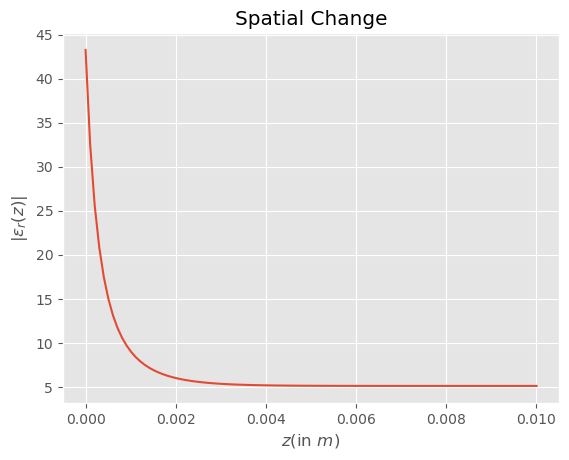

In [15]:
E = omega/vp
def Gamma(z):
    return 0.5*np.exp(-E*z)
def dGamma_dz(z):
    return 0.5*(-E)*np.exp(-E*z)
def a(z):
    return -2 * dGamma_dz(z) * 1/(1-(Gamma(z))**2)
def b(z):
    return 4*omega*np.sqrt(mu_0) * (Gamma(z)/(1-(Gamma(z))**2))
def I(z):
    integrand = lambda x: -a(x)
    result, _ = quad(integrand, L, z)
    return np.exp(result)
# Compute the values of I(z) and the integrand
I_values = [I(z) for z in z_vals]
integrand_values = [I(z) * b(z) for z in z_vals]

# Compute the integral using numerical integration
integral_values = []
for i in range(len(z_vals)):
    integral, _ = quad(lambda x: I(x) * b(x), L, z_vals[i])
    integral_values.append(integral)
eps = [ ( (I_values[i])/( I_values[dL-1]*(Z_L/np.sqrt(mu_0)) + 1j*integral_values[i] ) )**2 for i in range(0, dL) ]
plt.plot(z_vals, [(constants.speed_of_light/vp)**2*(abs(val)/constants.epsilon_0) for val in eps])
plt.xlabel('$z$(in $m$)')
plt.ylabel('$|\epsilon_r(z)|$')
plt.title('Spatial Change')
plt.show()

## Temporal

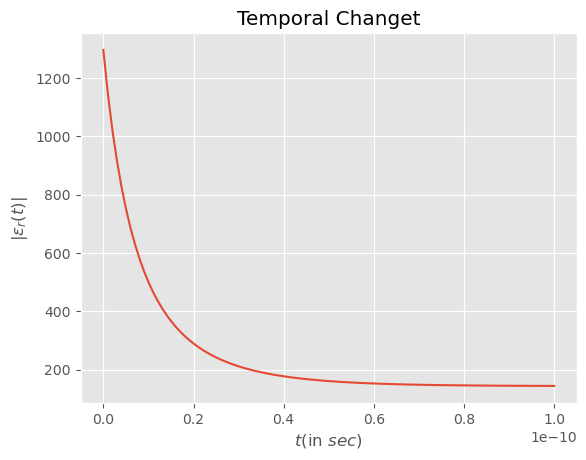

In [16]:
# Defining Gamma
F = omega
def Gamma(t):
    return 0.5-0.5*np.exp(-F*t)
def dGamma_dt(t):
    return -0.5*(-F)*np.exp(-F*t)
# defining a from hese values
def a(t):
    return -2 * dGamma_dt(t) * 1/(1-(Gamma(t))**2)
def b(t):
    return 4*omega*np.sqrt(mu_0) * (Gamma(t)/(1-(Gamma(t))**2))

# convert a and b to arrays
T = 1e-10
dT = 100
t_vals = np.linspace(0, T, dT)

a_r = [a(t_val) for t_val in t_vals]
b_r = [b(t_val) for t_val in t_vals]
I = [ np.exp(quad(a, 0, t_val)[0]) for t_val in t_vals ]

# We first find I(z)b(z) and we interpolate this function
d = [ (I[i]*b_r[i]) for i in range(0, 100) ]
d_interp = interp1d(np.linspace(0, T, 100), d, kind='cubic')
D = [ quad(d_interp, 0, t_val)[0] for t_val in t_vals ]

dGamma_dt_r = [dGamma_dt(t_val) for t_val in t_vals]
xi_0 = np.sqrt((constants.speed_of_light/vp)**2*constants.epsilon_0) # Changing the initial condition to what makes sense in an on-chip DiCAD
xi_0
eps = [ ( (I[i])/( I[0]*( 1/xi_0  ) - 1j*D[i] ) )**2 for i in range(0, dT) ]

plt.plot(t_vals, [(constants.speed_of_light/vp)**2*(abs(val)/constants.epsilon_0) for val in eps])
plt.xlabel('$t$(in $sec$)')
plt.ylabel('$|\epsilon_r(t)|$')
plt.title('Temporal Changet')
plt.show()